# **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense , LSTM , Embedding
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import data_table
data_table.enable_dataframe_formatter()

Mounted at /content/drive


# DO not RUN

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NewsData/News_headline_dataset_augmented.csv',encoding='utf-8')

In [ ]:
data.count()

headline          140753
category          140756
newspaper name    140756
dtype: int64

In [ ]:
class_count = data.groupby('category').count()
class_count

,headline,newspaper name
category,,
Amusement,15820,15820
IT,13325,13325
International,45954,45955
national,24622,24622
politics,10202,10202
sports,30830,30832


In [ ]:
data= data.drop_duplicates()

In [ ]:
data.to_csv("/content/drive/MyDrive/NewsData/News_headline_final_dataset.csv",index=False)

# RUN

In [3]:
data = pd.read_csv('/content/drive/MyDrive/NewsData/News_headline_final_dataset.csv',encoding='utf-8')

In [4]:
class_count = data.groupby('category').count()
class_count

,headline,newspaper name
category,,
Amusement,15820,15820
IT,13322,13322
International,45954,45955
national,24622,24622
politics,10202,10202
sports,30830,30832


Total number of headlines: 140753


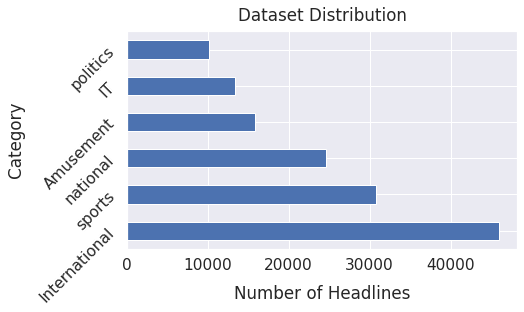

In [5]:
print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['category'].value_counts().plot(kind='barh', figsize=(7, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [6]:
# Length of each headlines
data['headline'] = data['headline'].astype(str)
data['length'] = data['headline'].apply(lambda x:len(x.split()))
print(data['length'])
# Remove the headlines with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Headlines".format(len(data)-len(dataset)),
      "\nTotal Headlines:",len(dataset))

0         4
1         4
2         4
3         4
4         7
         ..
140748    2
140749    7
140750    3
140751    4
140752    9
Name: length, Length: 140753, dtype: int64
After Cleaning: 
Removed 2235 Small Headlines 
Total Headlines: 138518


In [7]:
class_count = dataset.groupby('category').count()
class_count

,headline,newspaper name,length
category,,,
Amusement,15423,15423,15423
IT,13280,13280,13280
International,45621,45621,45621
national,24211,24211,24211
politics,10190,10190,10190
sports,29793,29793,29793


In [ ]:
#data.replace({'category':{'editors':0,'it':1,'islam':2,'sports':3,'national':4, 'international':5, 'bangladesh':6, 'entertainment':7}},inplace=True)

In [8]:
X = dataset['headline']
Y = dataset['category']

In [9]:
def make_balanced_data_per_class(X, Y, eq_length, category):
  new_Y = np.array(Y)
  new_X = np.array(X)
  cnt = 0
  data_list = []
  label_list = []
  for i in range(len(new_Y)):
    if new_Y[i] == category:
      if cnt<eq_length:
        data_list.append(new_X[i])
        label_list.append(new_Y[i])
        cnt = cnt+1
  return data_list, label_list

In [10]:
amusement_data, amusement_label = make_balanced_data_per_class(X, Y, 10190, 'Amusement')
it_data, it_label = make_balanced_data_per_class(X, Y, 10190, 'IT')
international_data, international_label = make_balanced_data_per_class(X, Y, 10190, 'International')
national_data, national_label = make_balanced_data_per_class(X, Y, 10190, 'national')
politics_data, politics_label = make_balanced_data_per_class(X, Y, 10190, 'politics')
sports_data, sports_label = make_balanced_data_per_class(X, Y, 10190, 'sports')

In [11]:
dataset = pd.DataFrame()
dataset['headline']     = amusement_data + it_data + international_data + national_data + politics_data + sports_data
dataset['category']  = amusement_label + it_label + international_label + national_label + politics_label + sports_label
len(dataset)

61140

Total number of headlines: 61140


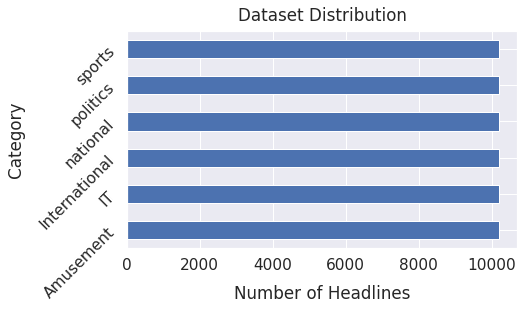

In [12]:
print(f'Total number of headlines: {len(dataset)}')
sns.set(font_scale=1.4)
dataset['category'].value_counts().plot(kind='barh', figsize=(7, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [13]:
class_count = dataset.groupby('category').count()
class_count

,headline
category,
Amusement,10190
IT,10190
International,10190
national,10190
politics,10190
sports,10190


In [14]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      #print(headlines)
      return headlines
# Apply the function into the dataframe
dataset['cleaned'] = dataset['headline'].apply(cleaning_data)  
print(dataset['cleaned'][5])

# print some cleaned reviews from the dataset
sample_data = [200,1200,9860,15000,26000,35000,46000,54000,60000]
for i in sample_data:
  print('Original: ',data.headline[i],'\nCleaned:',
           dataset.cleaned[i],'\n','Category:--> ',dataset.category[i],'\n')

মোহিনী নাচের জাদুতে আগুন জ্বালালেন ঊর্বশী   ভিডিও 
Original:  তিন দিনব্যাপী মাইক্রোচিপ ২০২০ এর [UNK] বিজ্ঞাপন 
Cleaned:  শাহরুখই ভুয়া কাগজ করতে বলছিলেন  
 Category:-->  Amusement 

Original:  প্রেমের গল্প প্রতিযোগিতা 
Cleaned: ঈদে হুমায়ূন আহমেদের সাত নাটক 
 Category:-->  Amusement 

Original:  বৈশাখী ল্যাপটপ মেলা সোমবার 
Cleaned: চার ফিল্ম নিয়ে নেটফ্লিক্সের সঙ্গে যুক্ত হলেন অ্যাডাম স্যান্ডলার 
 Category:-->  Amusement 

Original:  রিজিওনাল অ্যান্ড রিমোট সার্ভিসেসে চ্যাম্পিয়ন র‌্যাডিসন টেকনোলজিস 
Cleaned: কুকুর হলে বিদ্যুৎ যাবে রিমোটে 
 Category:-->  IT 

Original:  সৌদি সামরিক ঘাঁটিতে ক্ষেপণাস্ত্র হামলা চালাল ইয়েমেন 
Cleaned: উত্তর মেরুতে বোমারু বিমান পাঠিয়েছে রাশিয়া 
 Category:-->  International 

Original:  মোদির সাক্ষাতে পাল্টে গেলেন মমতা 
Cleaned: ঈদের আগে পরে ৭ দিন বন্ধ পণ্যবাহী গাড়ি চলাচল 
 Category:-->  national 

Original:  আফগানিস্তানের সঙ্গে পরাজয়ের চার কারণ 
Cleaned: অবশেষে সেই রহস্যের জট খুললেন সোহেল তাজ 
 Category:-->  politics 

Original:  কাশ্মীরে রাষ্ট্রপতি শাসনের মেয়াদ

In [15]:

def data_summary(dataset):
    
    """
    This function will print the summary of the headlines and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.category.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.category==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.category==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.category==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)


Class Name :  Amusement
Number of Documents:10190
Number of Words:62435
Number of Unique Words:13111
Most Frequent Words:

নিয়ে	731
নতুন	652
ও	575
গান	441
ভিডিও	388
না	322
খান	287
পর	262
সঙ্গে	261
চলচ্চিত্র	250

Class Name :  IT
Number of Documents:10190
Number of Words:60821
Number of Unique Words:8722
Most Frequent Words:

নতুন	571
ফেসবুক	460
ও	432
থেকে	316
স্মার্টফোন	282
মোবাইল	267
ডিজিটাল	261
বাংলাদেশ	250
শুরু	245
গুগল	215

Class Name :  International
Number of Documents:10190
Number of Words:67931
Number of Unique Words:12495
Most Frequent Words:

নিহত	646
না	524
সৌদি	486
নিয়ে	408
থেকে	358
ভিডিও	345
ভারতের	291
ভারত	282
সঙ্গে	279
ভারতে	270

Class Name :  national
Number of Documents:10190
Number of Words:66417
Number of Unique Words:13280
Most Frequent Words:

হবে	581
না	561
ও	504
প্রধানমন্ত্রী	500
আজ	326
থেকে	289
বাংলাদেশ	260
সরকার	231
প্রধানমন্ত্রীর	228
করতে	226

Class Name :  politics
Number of Documents:10190
Number of Words:73141
Number of Unique Words:10398
Most Frequent Wor

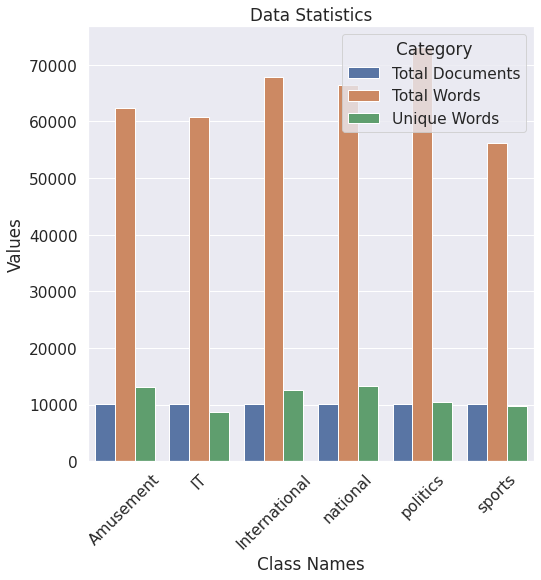

In [16]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 8))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

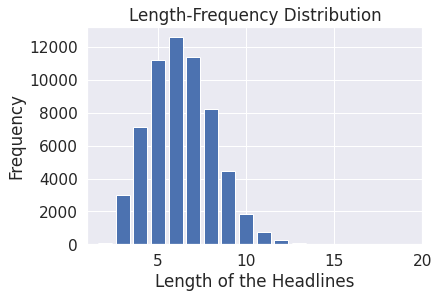

Maximum Length of a headline: 21
Minimum Length of a headline: 0
Average Length of a headline: 6.0


In [17]:
dataset['HeadlineLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.HeadlineLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a headline: {max(dataset.HeadlineLength)}")
print(f"Minimum Length of a headline: {min(dataset.HeadlineLength)}")
print(f"Average Length of a headline: {round(np.mean(dataset.HeadlineLength),0)}")

In [18]:
                                       #==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(category,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        category: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(category)
    encoded_labels = le.transform(category)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(category[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(headlines,category):
    """
    This function will return the splitted (90%-10%-10%) feature vector . 
    
    Args:
        headlines: sequenced headlines 
        category: encoded lables (array) 
        
    Returns:
        X_train: training data 
        X_valid: validation data
        X_test : testing feature vector 
        y_train: training encoded labels (array) 
        y_valid: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [19]:
labels = label_encoding(dataset.category,True)


			===== Label Encoding ===== 
Class Names:--> ['Amusement' 'IT' 'International' 'national' 'politics' 'sports']
Amusement   0 

Amusement   0 

Amusement   0 

IT   1 

International   2 

national   3 

politics   4 

sports   5 

sports   5 



In [20]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.headline,labels)
X_train.count()


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 61140 
	Training		 44020 
	Test			 6114 
	Validation		 11006


44020

In [21]:
vocab_size = 57000
embedding_dim = 64
max_length = 21
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

def padded_headlines(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(original,"\n",encoded) 
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)

In [22]:
 #Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [23]:
#============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
unk 	 3960
না 	 1973
ও 	 1562
নিয়ে 	 1524
নতুন 	 1303
হবে 	 1152
থেকে 	 1117
খালেদা 	 1005
সঙ্গে 	 845
বাংলাদেশ 	 838

Words --> Documents:
unk 	 2872
না 	 1919
ও 	 1542
নিয়ে 	 1520
নতুন 	 1284
হবে 	 1147
থেকে 	 1117
খালেদা 	 1005
সঙ্গে 	 841
বাংলাদেশ 	 832

Words --> Index:
বটে 	 35216
বোলার’ 	 35215
‘শিশু 	 35214
জমজ 	 35213
শিখি 	 35212
কিচ্ছা 	 35211
নাগর 	 35210
স্বরচিত 	 35209
গণবক্তৃতা 	 35208
প্রগতির 	 35207

Total Documents --> 44020
Found 35216 unique tokens


In [24]:
padded_headlines(X_train[10],train_sequences[10],train_padded[10])


			====== Encoded Sequences ====== 

মোদির পাশে তৈমুর! 
 [424, 465, 6398, 5715, 1903, 539]

			====== Paded Sequences ======
 মোদির পাশে তৈমুর! 
 [ 424  465 6398 5715 1903  539    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [25]:
X_valid

3394                                     খোঁজ নেই বিন্দুর
21075           তুরস্কের প্রথম পরমাণু কেন্দ্র নির্মাণ শুরু
6136                       সাত বছর পর জেমসের নতুন অ্যালবাম
14701                চালকের অবস্থা [UNK] [UNK] ১ ( দৃশ্য )
44876           অপকর্ম করলে কেউ ছাড় পাবে না: ওবায়দুল কাদের
                               ...                        
25699    নেপালে বিমান বিধ্বস্তের আগ মুহূর্তের ভিডিও প্রকাশ
21482                বরিস জনসনকে নিয়ে যা বলছে ইরানি মিডিয়া
3879         "বিদেশে যেভাবে চলে মধুচক্র, জড়িত দুই নায়িকা!"
16520                 ওয়ালটন মেগা রেডিও কমিউনিকেশনের অফার
46448    নির্বাচনকালীন সময়ে সংসদ ভেঙে দেয়ার দাবি নিষ্প্...
Name: headline, Length: 11006, dtype: object

In [27]:
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_valid[46448],validation_sequences[1],validation_padded[1])


			====== Encoded Sequences ====== 

নির্বাচনকালীন সময়ে সংসদ ভেঙে দেয়ার দাবি নিষ্প্রয়োজন: কাদের 
 [476, 36, 532, 1049, 594, 21]

			====== Paded Sequences ======
 নির্বাচনকালীন সময়ে সংসদ ভেঙে দেয়ার দাবি নিষ্প্রয়োজন: কাদের 
 [ 476   36  532 1049  594   21    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [28]:
X_test

34579    ‘প্রেসিডেন্টকে উকিল নোটিশে রাষ্ট্রের ভাবমর্যাদ...
5110           পিঙ্ক সিটিতে বাংলাদেশি নির্মাতার ‘প্রতিভাস’
44700    মওদুদ আহমেদ নির্বাচনী এলাকায় জনবিচ্ছিন্ন: ওবায়...
35517    ৭ম বারের মতো এগিয়ে রাজশাহী সবার পেছনে সিলেট বোর্ড
12561            ডিজিটাল বাংলাদেশের সক্ষমতা তৈরির প্রয়োজন
                               ...                        
60644                           বেসামরিক জীবনে ফিরলেন ধোনি
37668            রিমান্ড শেষে জি কে শামীম ও খালেদ কারাগারে
19535    যে ১০ এক্সটেনশন [UNK] জানাবেন স্মার্টফোন সম্পর্কে
18163                    রাজশাহীতে সিগারেট মারলে ১০০ টাকা!
24218    উইঘুর মুসলমানদের আটকে রাখার ক্যাম্পগুলোকে বৈধত...
Name: headline, Length: 6114, dtype: object

In [30]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_test[24218],test_sequences[100],test_padded[100])


			====== Encoded Sequences ====== 

উইঘুর মুসলমানদের আটকে রাখার ক্যাম্পগুলোকে বৈধতা দিচ্ছে চীন 
 [1, 4098, 2618, 1, 2325]

			====== Paded Sequences ======
 উইঘুর মুসলমানদের আটকে রাখার ক্যাম্পগুলোকে বৈধতা দিচ্ছে চীন 
 [   1 4098 2618    1 2325    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [31]:
test_padded.shape[1]

21

In [34]:
# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.category)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

print(train_label_seq.shape)
print(valid_label_seq.shape)
print(testing_label_seq.shape)

(44020,)
(11006,)
(6114,)


# LSTM

In [44]:
### trying to lstm

keras.backend.clear_session()
from keras import optimizers
from keras.layers import Dropout
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM
#accuracy_threshold = 100.1
vocab_size = 57000
embedding_dim = 64
max_length = 21
num_category = 6

#class myCallback(keras.callbacks.Callback):
  #def on_epoch_end(self, epoch, logs={}):
      #if(logs.get('accuracy')>accuracy_threshold):
       # print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        #self.model.stop_training = True

#acc_callback = myCallback()
# Saved the Best Model
filepath ="/content/drive/MyDrive/NewsData/Model_lstm.h6"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
#callback_list = [checkpoint] 
'''
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(128, return_sequences = True)),
    tf.keras.layers.Bidirectional(LSTM(128)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])
'''
'''
Adding Regularization
L1 ===>  tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)), # adding L1 regularization
L2 ===>  tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # adding L2 regularization
'''

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    #tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    
    tf.keras.layers.Dense(num_category, activation='softmax')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
#adamW = tf.keras.optimizers.experimental.AdamW(learning_rate=0.002)
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 64)            3648000   
                                                                 
 lstm (LSTM)                 (None, 256)               328704    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4,010,374
Trainable params: 4,010,374
Non-

In [45]:
num_epochs = 11
batch = 16
history = model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1, 
                    callbacks = checkpoint)

Epoch 1/11
2752/2752 [==============================] - ETA: 0s - loss: 1.1776 - accuracy: 0.5648
Epoch 1: val_accuracy improved from -inf to 0.76495, saving model to /content/drive/MyDrive/NewsData/Model_lstm.h6


2752/2752 [==============================] - 35s 12ms/step - loss: 1.1776 - accuracy: 0.5648 - val_loss: 0.7525 - val_accuracy: 0.7649
Epoch 2/11
2752/2752 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.8383
Epoch 2: val_accuracy improved from 0.76495 to 0.80883, saving model to /content/drive/MyDrive/NewsData/Model_lstm.h6


2752/2752 [==============================] - 26s 9ms/step - loss: 0.5527 - accuracy: 0.8383 - val_loss: 0.6305 - val_accuracy: 0.8088
Epoch 3/11
2752/2752 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.9110
Epoch 3: val_accuracy did not improve from 0.80883
2752/2752 [==============================] - 22s 8ms/step - loss: 0.3309 - accuracy: 0.9110 - val_loss: 0.6950 - val_accuracy: 0.8088
Epoch 4/11
2752/2752 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9473
Epoch 4: val_accuracy improved from 0.80883 to 0.81010, saving model to /content/drive/MyDrive/NewsData/Model_lstm.h6


2752/2752 [==============================] - 28s 10ms/step - loss: 0.2206 - accuracy: 0.9473 - val_loss: 0.7086 - val_accuracy: 0.8101
Epoch 5/11
2745/2752 [============================>.] - ETA: 0s - loss: 0.1634 - accuracy: 0.9635
Epoch 5: val_accuracy did not improve from 0.81010
2752/2752 [==============================] - 21s 8ms/step - loss: 0.1634 - accuracy: 0.9635 - val_loss: 0.7267 - val_accuracy: 0.8069
Epoch 6/11
2749/2752 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9749
Epoch 6: val_accuracy did not improve from 0.81010
2752/2752 [==============================] - 22s 8ms/step - loss: 0.1217 - accuracy: 0.9749 - val_loss: 0.8511 - val_accuracy: 0.8080
Epoch 7/11
2750/2752 [============================>.] - ETA: 0s - loss: 0.1062 - accuracy: 0.9782
Epoch 7: val_accuracy did not improve from 0.81010
2752/2752 [==============================] - 20s 7ms/step - loss: 0.1061 - accuracy: 0.9782 - val_loss: 0.9835 - val_accuracy: 0.7922
Epoch 8/11
2749/

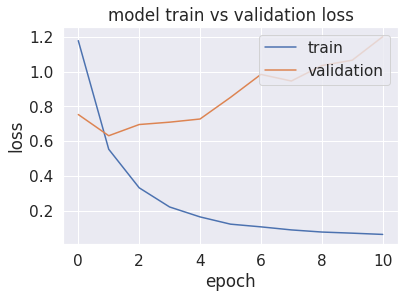

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

192/192 [==============================] - 1s 2ms/step
[3 0 4 ... 1 1 2]


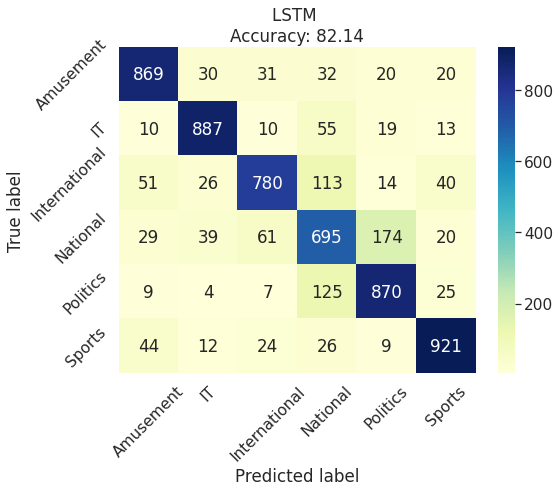

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
## model.h5 - gru
## model.h6 -lstm 

#model = load_model("/content/drive/MyDrive/NewsData/Model.h5")

model = load_model("/content/drive/MyDrive/NewsData/Model_lstm.h6")

predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)
print(y_pred)

cm = confusion_matrix(testing_label_seq, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     
                     index = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'], 
                     columns = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('LSTM \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [43]:
report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Amusement','1':'IT','2':'International','3':'national','4':'politics','5':'sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report 

,precision,recall,f1-score,support
Amusement,85.48,87.52,86.49,1002.000000
IT,91.23,86.82,88.97,994.000000
International,80.00,80.08,80.04,1024.000000
national,69.19,57.37,62.73,1018.000000
politics,77.40,88.27,82.48,1040.000000
sports,86.84,91.12,88.93,1036.000000
accuracy,81.88,81.88,81.88,0.818777
macro avg,81.69,81.86,81.61,6114.000000
weighted avg,81.64,81.88,81.59,6114.000000


# **LIME**

In [ ]:
%%capture
!pip install lime 

In [ ]:
import lime
from lime.lime_text import LimeTextExplainer
import torch.nn.functional as F

In [ ]:
class_names = ['Amusement','IT','International','national','politics', 'sports']
print(class_names)
headlines = X_test
labels = pd.Series(y_test)
print(labels)
headlines = headlines.reset_index(drop=True)
#labels = labels.reset_index(drop=True)

['Amusement', 'IT', 'International', 'national', 'politics', 'sports']
0       5
1       2
2       3
3       3
4       5
       ..
6109    0
6110    0
6111    1
6112    2
6113    2
Length: 6114, dtype: int64


In [ ]:
def predict_proba(arr):
  processed=[]
  for i in arr:

    processed.append(cleaning_data(i))
    #print(processed)
  list_tokenized_ex = tokenizer.texts_to_sequences(processed)
  Ex = pad_sequences(list_tokenized_ex, maxlen=max_length)
  pred=model.predict(Ex)
  #print(pred, 'this is pred value')
  #returnable=[]
  #for i in pred:
    #temp=i[0]
    #print(temp, 'this is temp')
    #returnable.append(np.array([1-temp,temp])) #I would recommend rounding temp and 1-temp off to 2 places
  return np.array(pred)

## RUN

In [ ]:
import random
idx = random.randint(0, len(headlines))
str_to_predict = headlines[idx]

In [ ]:
print(str_to_predict, ' ', labels[idx])
probability_1 = predict_proba(str_to_predict)
#probability = np.argmax(probability_1[0])
print(probability_1.shape)
#print(probability)

ফেসবুকের মধ্যে বিশৃঙ্খলার [UNK] কোন ফেসবুক?   1
2/2 [==============================] - 0s 8ms/step
(43, 6)


In [ ]:
##
explainer = LimeTextExplainer(class_names=class_names, split_expression=' ')
exp = explainer.explain_instance(str_to_predict, predict_proba, labels=(0,1,2,3,4,5))
print(exp.available_labels())
#print('Predicted class =', class_names[nb.predict(headlines[idx]).reshape(1,-1)[0,0]])
#print('True class: %s' % class_names[newsgroups_test.target[idx]])

157/157 [==============================] - 0s 2ms/step
[0, 1, 2, 3, 4, 5]


In [ ]:
actual_category = labels[idx]
if actual_category == 0:
  cat = 'Amusement'
elif actual_category == 1:
  cat = 'IT'
elif actual_category == 2:
  cat = 'International'
elif actual_category == 3:
  cat = 'national'
elif actual_category == 4:
  cat = 'politics'
else: cat = 'sports' 

In [ ]:
print("Actual Category:", cat)
exp.show_in_notebook(text=True, labels=(2,))
#explainer.explain_instance(str_to_predict,predict_proba).show_in_notebook(max_prob_label=pred, text=True)

Actual Category: IT


In [ ]:
exp_label = exp.available_labels()

for i in exp_label:
    print(class_names[i], " ",exp.as_list(label=i), end="\n\n")

Amusement   [('আতিকুল', -0.0034299343720676583), ('সাক্ষাৎ', -0.003218112136730623), ('মেয়র', -0.0031160346238845705), ('রাষ্ট্রদূতের', -0.00310870010402364), ('সাথে', -0.003102284915673965), ('স্পেন', -0.0022296171429122993), ('ইসলামের', 0.001540395144703105)]

IT   [('আতিকুল', -0.0018767680219492315), ('সাথে', -0.0017430204790678447), ('সাক্ষাৎ', -0.001706341119031997), ('মেয়র', -0.001666770966387237), ('রাষ্ট্রদূতের', -0.0012340728007051234), ('ইসলামের', 0.0006013460079906303), ('স্পেন', -0.0004067861838769656)]

International   [('আতিকুল', -0.0022100546252952777), ('সাথে', -0.001970795203944342), ('সাক্ষাৎ', -0.001925178847756423), ('মেয়র', -0.001641006603426791), ('রাষ্ট্রদূতের', -0.0014713691246438997), ('ইসলামের', 0.0006861173910591871), ('স্পেন', -0.00040810142525391776)]

national   [('আতিকুল', 0.042414152881021495), ('সাথে', 0.040846779151084006), ('মেয়র', 0.029166543456907574), ('সাক্ষাৎ', 0.02855928594838314), ('রাষ্ট্রদূতের', 0.02663456056327318), ('স্পেন', -0.011004951028

In [ ]:
exp.as_list()

[('আতিকুল', -0.0018767680219492315),
 ('সাথে', -0.0017430204790678447),
 ('সাক্ষাৎ', -0.001706341119031997),
 ('মেয়র', -0.001666770966387237),
 ('রাষ্ট্রদূতের', -0.0012340728007051234),
 ('ইসলামের', 0.0006013460079906303),
 ('স্পেন', -0.0004067861838769656)]